In [7]:
import torch
height = width = 16

height_gap = 2 / (height - 1)
width_gap = 2 / (width - 1)
height, width = torch.meshgrid([torch.range(-1, 1, height_gap), torch.Tensor(1)])

print(torch.range(-1, 1, height_gap))
print(height)

print(width)

lr_identity = torch.stack([width, height])


print(lr_identity.shape)

tensor([-1.0000, -0.8667, -0.7333, -0.6000, -0.4667, -0.3333, -0.2000, -0.0667,
         0.0667,  0.2000,  0.3333,  0.4667,  0.6000,  0.7333,  0.8667,  1.0000])
tensor([[-1.0000],
        [-0.8667],
        [-0.7333],
        [-0.6000],
        [-0.4667],
        [-0.3333],
        [-0.2000],
        [-0.0667],
        [ 0.0667],
        [ 0.2000],
        [ 0.3333],
        [ 0.4667],
        [ 0.6000],
        [ 0.7333],
        [ 0.8667],
        [ 1.0000]])
tensor([[-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10],
        [-2.5206e+10]])
torch.Size([2, 16, 1])


/home/lrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  
/home/lrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: torch.range is deprecated in favor of torch.arange and will be removed in 0.5. Note that arange generates values in [start; end), not [start; end].
  


In [8]:
a = {}
a['b'] = 2
a['c'] = 10

for k,v in a.items():
    print(k,v)

b 2
c 10


In [27]:
a = [1,2,3,4]
def func(a):
    yield a[0], a[1], a[2], a[3]
    
for i in func(a):
    print(i)

(1, 2, 3, 4)


In [10]:
a = [1,2,3,4]
print(set(a))
def func(a):
    yield a[0]
    for i in range(len(a[1:])):
        yield a[i]
    
for i in func(a):
    print(i)

{1, 2, 3, 4}
1
1
2
3


In [8]:
a = True
b = True

a and b


import random
a = random.random()
print(a < 0.5)

b = b and random.random() < 0.5

True


In [33]:
import torch
idx_data = 0
a = torch.rand([5,2,7])
print(a)
b, epoch_idx = a.max(0)
best, frame_idx = b.max(1)
print(epoch_idx)
print(best)
print(frame_idx)


best_frame_idx = frame_idx[idx_data]
print(best_frame_idx)
best_epoch_idx = epoch_idx[idx_data, frame_idx[idx_data]]
print(best_epoch_idx)

print(a[best_epoch_idx, idx_data, best_frame_idx])

tensor([[[0.1125, 0.0370, 0.6710, 0.5348, 0.2894, 0.0667, 0.8933],
         [0.3755, 0.0887, 0.2387, 0.1364, 0.8433, 0.7600, 0.1243]],

        [[0.5831, 0.8836, 0.1273, 0.1217, 0.4045, 0.5854, 0.7010],
         [0.4792, 0.2392, 0.5454, 0.1688, 0.6365, 0.1348, 0.4151]],

        [[0.3612, 0.9961, 0.6048, 0.1472, 0.2493, 0.0070, 0.1248],
         [0.5126, 0.4510, 0.1868, 0.2796, 0.9079, 0.4147, 0.4538]],

        [[0.7900, 0.3607, 0.0517, 0.5220, 0.5259, 0.4017, 0.4916],
         [0.0316, 0.8550, 0.5969, 0.3263, 0.8754, 0.4712, 0.7224]],

        [[0.6447, 0.5663, 0.3825, 0.6076, 0.1682, 0.6950, 0.5634],
         [0.5846, 0.8258, 0.8737, 0.4210, 0.7571, 0.5408, 0.4368]]])
tensor([[3, 2, 0, 4, 3, 4, 0],
        [4, 3, 4, 4, 2, 0, 3]])
tensor([0.9961, 0.9079])
tensor([1, 4])
tensor(1)
tensor(2)
tensor(0.9961)


In [44]:
a = '10'

try:
    print("frame" + str(a))
except:
    raise TypeError("a should be int type")

frame10


In [46]:
import torch
a = torch.rand([5,2,7])

print(a.shape[0])

5


In [61]:
from tqdm import tqdm
import numpy as np
from time import sleep
for idx, i in enumerate(tqdm(np.arange(100))):
    print(idx)
    sleep(0.01)

 20%|██        | 20/100 [00:00<00:00, 98.14it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


 30%|███       | 30/100 [00:00<00:00, 98.29it/s]

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


 50%|█████     | 50/100 [00:00<00:00, 98.17it/s]

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


 70%|███████   | 70/100 [00:00<00:00, 98.03it/s]

60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


 90%|█████████ | 90/100 [00:00<00:00, 98.01it/s]

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


100%|██████████| 100/100 [00:01<00:00, 98.00it/s]


In [1]:
import torch

a = torch.tensor([3,4,5])

print(a)

print("a is {}".format(a))



tensor([3, 4, 5])
a is tensor([3, 4, 5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4.375552
-9.264002
(256, 448, 2)
torch.Size([1, 3, 256, 448])
tensor([[[[  0.,   1.,   2.,  ..., 445., 446., 447.],
          [  0.,   1.,   2.,  ..., 445., 446., 447.],
          [  0.,   1.,   2.,  ..., 445., 446., 447.],
          ...,
          [  0.,   1.,   2.,  ..., 445., 446., 447.],
          [  0.,   1.,   2.,  ..., 445., 446., 447.],
          [  0.,   1.,   2.,  ..., 445., 446., 447.]],

         [[  0.,   0.,   0.,  ...,   0.,   0.,   0.],
          [  1.,   1.,   1.,  ...,   1.,   1.,   1.],
          [  2.,   2.,   2.,  ...,   2.,   2.,   2.],
          ...,
          [253., 253., 253.,  ..., 253., 253., 253.],
          [254., 254., 254.,  ..., 254., 254., 254.],
          [255., 255., 255.,  ..., 255., 255., 255.]]]])


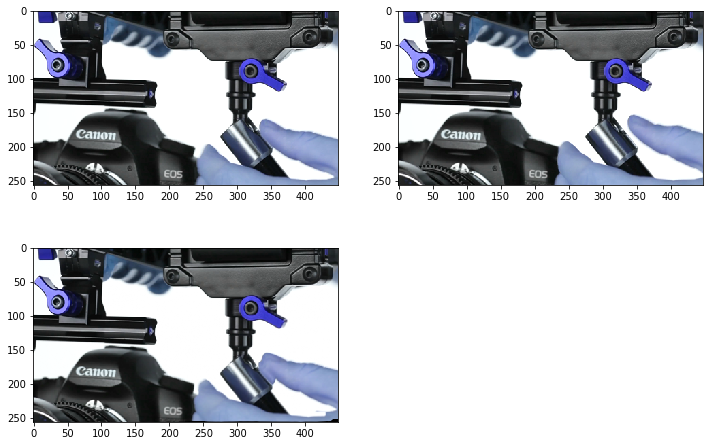

In [49]:
import numpy as np
import os

TAG_FLOAT = 202021.25
import torch.nn as nn
def read_flow(file):

    assert type(file) is str, "file is not str %r" % str(file)
    assert os.path.isfile(file) is True, "file does not exist %r" % str(file)
    assert file[-4:] == '.flo', "file ending is not .flo %r" % file[-4:]
    f = open(file,'rb')
    flo_number = np.fromfile(f, np.float32, count=1)[0]
    assert flo_number == TAG_FLOAT, 'Flow number %r incorrect. Invalid .flo file' % flo_number
    w = np.fromfile(f, np.int32, count=1)
    h = np.fromfile(f, np.int32, count=1)
    data = np.fromfile(f, np.float32, count=2*w[0]*h[0])
    #if error try: data = np.fromfile(f, np.float32, count=2*w*h)
    # Reshape data into 3D array (columns, rows, bands)
    flow = np.resize(data, (int(h), int(w), 2))
    f.close()

    return flow

def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow.
    Code heavily inspired by
    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow
    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()
    #print(grid)
    grid = grid
    vgrid = grid + flo

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0*vgrid[:, 0, :, :]/max(W-1, 1)-1.0
    vgrid[:, 1, :, :] = 2.0*vgrid[:, 1, :, :]/max(H-1, 1)-1.0
    vgrid = vgrid.permute(0, 2, 3, 1)
    output = nn.functional.grid_sample(x, vgrid)
    # Define a first mask containing pixels that wasn't properly interpolated
    mask = torch.autograd.Variable(torch.ones(x.size()))
    mask = nn.functional.grid_sample(mask, vgrid)
    mask[mask < 0.9999] = 0
    mask[mask > 0] = 1

    return output, mask


filename = "/home/lrh/git/blind-denoising/tvl1flow/of/tvl1_target.flo"

of = read_flow(filename)
print(of.max())
print(of.min())

print(of.shape)

of = torch.tensor(of).unsqueeze(0).permute(0,3,1,2)

image_path = "/home/lrh/git/blind-denoising/tvl1flow/image/target/im3.png"
import imageio
import torch
image_np = cv2.imread(image_path)
image_tensor = torch.tensor(image_np).type(torch.FloatTensor).unsqueeze(0).permute(0,3,1,2)
print(image_tensor.shape)

o, m = warp(image_tensor, -of)

from matplotlib import pyplot as plt

target_path = "/home/lrh/git/blind-denoising/tvl1flow/image/target/im4.png"
image_target = cv2.imread(target_path)


plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(image_np)

plt.subplot(222)
plt.imshow(image_target)

plt.subplot(223)
plt.imshow(o[0].permute(1,2,0).numpy() / 255.0)

plt.show()

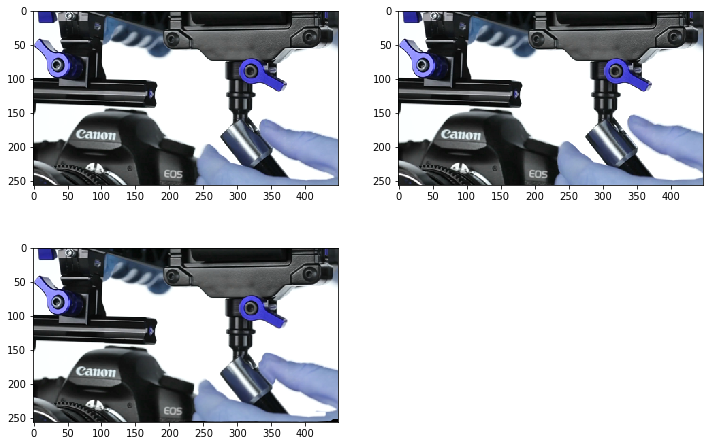

In [46]:
import cv2
import numpy as np
from imageio import imread
img_file = '/home/lrh/git/blind-denoising/tvl1flow/image/target/im3.png'
img2_file = '/home/lrh/git/blind-denoising/tvl1flow/image/target/im4.png'

prev_frame =  cv2.imread(img_file)
next_frame = cv2.imread(img2_file)

flow_file = "/home/lrh/git/blind-denoising/tvl1flow/of/tvl1_target.flo"
flow = read_flow(flow_file)

def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = - flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

im2w = warp_flow(prev_frame, flow)


plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(prev_frame / 255.0)

plt.subplot(222)
plt.imshow(next_frame/255.0)

plt.subplot(223)
plt.imshow(im2w/255.0)

plt.show()